In [3]:
#!/usr/bin/env python3

import os
import numpy as np
import csv
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from collections import defaultdict

###############################
# STEP 1: FIND IMAGE PAIRS
###############################
def find_image_pairs(data_dir):
    temp = {}
    for fname in os.listdir(data_dir):
        full_path = os.path.join(data_dir, fname)
        if not os.path.isfile(full_path):
            continue
        
        if fname.endswith("_M04_max.tiff"):
            prefix = fname.replace("_M04_max.tiff", "")
            if prefix not in temp:
                temp[prefix] = {}
            temp[prefix]["M04"] = fname
        
        elif fname.endswith("_OC_max.tiff"):
            prefix = fname.replace("_OC_max.tiff", "")
            if prefix not in temp:
                temp[prefix] = {}
            temp[prefix]["OC"] = fname
    
    pairs_dict = {}
    for prefix, val in temp.items():
        if "M04" in val and "OC" in val:
            pairs_dict[prefix] = (val["M04"], val["OC"])
    
    return pairs_dict

###############################
# STEP 2: LOAD + THRESHOLD
###############################
def load_and_threshold(data_dir, m04_filename, oc_filename):
    m04_path = os.path.join(data_dir, m04_filename)
    oc_path  = os.path.join(data_dir, oc_filename)
    
    M04_img = imread(m04_path).astype(np.float64)
    OC_img  = imread(oc_path).astype(np.float64)
    
    m04_thresh = threshold_otsu(M04_img)
    oc_thresh  = threshold_otsu(OC_img)
    
    M04_mask = (M04_img > m04_thresh)
    OC_mask  = (OC_img  > oc_thresh)
    
    return M04_img, OC_img, M04_mask, OC_mask

###############################
# STEP 3: MEASURE AREAS
###############################
def measure_areas(M04_mask, OC_mask):
    combined_mask = M04_mask | OC_mask
    plaque_labels = label(combined_mask)
    
    m04_areas = []
    oc_areas  = []
    plaque_indices = []
    
    for prop in regionprops(plaque_labels):
        pid = prop.label
        plaque_indices.append(pid)
        
        plaque_mask = (plaque_labels == pid)
        m_area = np.sum(M04_mask[plaque_mask])
        o_area = np.sum(OC_mask[plaque_mask])
        
        m04_areas.append(m_area)
        oc_areas.append(o_area)
    
    return plaque_labels, m04_areas, oc_areas, plaque_indices

###############################
# HELPER: PER-IMAGE MEDIAN-BASED CLASSIFICATION
###############################
def classify_by_medians(m04_areas, oc_areas):
    """
    Return a list of "median_cat" for each plaque,
    using Inert/Dynamic/Filamentous/Other logic.
    """
    m04_areas = np.array(m04_areas, dtype=float)
    oc_areas  = np.array(oc_areas, dtype=float)
    
    median_m04 = np.median(m04_areas) if len(m04_areas) > 0 else 0.0
    median_oc  = np.median(oc_areas)  if len(oc_areas)  > 0 else 0.0
    
    cats = []
    for ma, oa in zip(m04_areas, oc_areas):
        m_label = "High" if ma > median_m04 else "Low"
        o_label = "High" if oa > median_oc  else "Low"
        
        if (m_label == "High") and (o_label == "Low"):
            cats.append("Inert")
        elif (m_label == "High") and (o_label == "High"):
            cats.append("Dynamic")
        elif (m_label == "Low") and (o_label == "High"):
            cats.append("Filamentous")
        else:
            cats.append("Other")
    return cats

###############################
# WE'LL STORE GLOBAL DATA HERE
###############################
global_plaques = []
# Each element: [prefix, plaque_id, m_area, o_area, median_cat, ratio, ratio_cat]
# Initially ratio_cat is None (we fill it after the rank-based classification)

# We'll also store a dictionary mapping prefix -> image area:
prefix_to_area = {}

###############################
def load_genotype_key(csv_path):
    genotype_map = {}
    with open(csv_path, 'r', encoding='utf-8-sig', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            key_prefix = row['prefix']
            gt = row['genotype']
            genotype_map[key_prefix] = gt
    return genotype_map

###############################
def write_ratio_counts_per_image(global_plaques, genotype_map, prefix_to_area,
                                 out_csv="ratio_counts_per_image.csv"):
    """
    Summarize how many plaques per image are Inert_ratio, Dynamic_ratio, Filamentous_ratio
    (and total), then add genotype info from genotype_map.
    We ALSO normalize these ratio-based counts by the image size (prefix_to_area[prefix]).
    
    global_plaques: list of [prefix, plaque_id, m04_area, oc_area, median_cat, ratio, ratio_cat]
      ratio_cat is one of {Inert_ratio, Dynamic_ratio, Filamentous_ratio}
    
    genotype_map: dict { prefix3 : genotype }
    
    prefix_to_area: dict { prefix : image_area_in_pixels }
      so we can do normalization
    
    out_csv: path to the output CSV.
    """
    ratio_counts_dict = defaultdict(lambda: {
        "Inert_ratio": 0,
        "Dynamic_ratio": 0,
        "Filamentous_ratio": 0,
        "Total": 0
    })
    
    # 1) Populate ratio_counts_dict
    for row in global_plaques:
        prefix, pid, ma, oa, median_cat, ratio_val, ratio_cat = row
        
        ratio_counts_dict[prefix]["Total"] += 1
        if ratio_cat in ratio_counts_dict[prefix]:
            ratio_counts_dict[prefix][ratio_cat] += 1
    
    # 2) Write results to CSV (with normalized columns)
    with open(out_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "ImagePrefix",
            "Inert_ratio",
            "Dynamic_ratio",
            "Filamentous_ratio",
            "TotalPlaques",
            "Inert_ratio_norm",
            "Dynamic_ratio_norm",
            "Filamentous_ratio_norm",
            "TotalPlaques_norm",  # if you want total normalized as well
            "Genotype"
        ])
        
        for prefix, counts in ratio_counts_dict.items():
            inert_r  = counts["Inert_ratio"]
            dyn_r    = counts["Dynamic_ratio"]
            fil_r    = counts["Filamentous_ratio"]
            total_r  = counts["Total"]
            
            # Lookup genotype
            prefix3  = prefix[:3]
            genotype = genotype_map.get(prefix3, "Unknown")
            
            # Lookup image area
            img_area = prefix_to_area.get(prefix, 1)  # fallback 1 to avoid div by zero
            
            # Normalized
            inert_r_norm  = inert_r / img_area
            dyn_r_norm    = dyn_r / img_area
            fil_r_norm    = fil_r / img_area
            total_r_norm  = total_r / img_area
            
            writer.writerow([
                prefix,
                inert_r,
                dyn_r,
                fil_r,
                total_r,
                f"{inert_r_norm:.6f}",
                f"{dyn_r_norm:.6f}",
                f"{fil_r_norm:.6f}",
                f"{total_r_norm:.6f}",
                genotype
            ])
    
    print(f"Wrote ratio counts per image (normalized) to: {out_csv}")


###############################
# MAIN WORKFLOW
###############################
def main():
    data_dir = '/Users/katherineridley/Projects/PlaqueDist/Masks'
    genotype_csv = '/Users/katherineridley/Projects/PlaqueDist/genotypekey.csv'
    
    detailed_csv = 'all_plaque_classifications.csv'
    summary_csv  = 'image_summary_with_genotype.csv'
    
    # Step A: Gather pairs
    pairs_dict = find_image_pairs(data_dir)
    if not pairs_dict:
        print("No valid image pairs found.")
        return
    print(f"Found {len(pairs_dict)} image pairs.")
    
    image_summaries = []
    genotype_map = load_genotype_key(genotype_csv)
    
    for prefix, (m04_file, oc_file) in pairs_dict.items():
        print(f"\nProcessing prefix: {prefix}")
        
        M04_img, OC_img, M04_mask, OC_mask = load_and_threshold(data_dir, m04_file, oc_file)
        plaque_labels, m04_areas, oc_areas, plaque_indices = measure_areas(M04_mask, OC_mask)
        
        median_cats = classify_by_medians(m04_areas, oc_areas)
        
        # Tally median-based
        inert_count       = sum(cat=="Inert"       for cat in median_cats)
        dynamic_count     = sum(cat=="Dynamic"     for cat in median_cats)
        fil_count         = sum(cat=="Filamentous" for cat in median_cats)
        other_count       = sum(cat=="Other"       for cat in median_cats)
        
        print(f"  MEDIAN CATEGORIES for {prefix}: Inert={inert_count}, Dynamic={dynamic_count}, Filamentous={fil_count}, Other={other_count}")
        
        # Add each plaque to global_plaques
        for pid, ma, oa, med_cat in zip(plaque_indices, m04_areas, oc_areas, median_cats):
            if ma==0 and oa>0:
                ratio = np.inf
            elif ma==0 and oa==0:
                ratio = 0.0
            else:
                ratio = oa/ma
            global_plaques.append([prefix, pid, ma, oa, med_cat, ratio, None])
        
        # For summary
        H, W = M04_img.shape
        img_area = H * W
        prefix_to_area[prefix] = img_area   # store in global dict, for ratio normalization
        genotype = genotype_map.get(prefix[:3], "Unknown")
        
        # Normalized
        in_norm  = inert_count/img_area
        dy_norm  = dynamic_count/img_area
        fil_norm = fil_count/img_area
        ot_norm  = other_count/img_area
        
        image_summaries.append([
            prefix, inert_count, dynamic_count, fil_count, other_count,
            genotype, img_area, in_norm, dy_norm, fil_norm, ot_norm
        ])
    
    # --- GLOBAL RANK-BASED CLASSIFICATION ---
    ratio_list = [(row[5], i) for i, row in enumerate(global_plaques)]  # row[5] = ratio
    ratio_list.sort(key=lambda x: x[0])
    N = len(ratio_list)
    i33 = N//3
    i66 = 2*N//3
    
    for rank,(r_val, idx) in enumerate(ratio_list):
        if rank<i33:
            global_plaques[idx][6] = "Inert_ratio"
        elif rank<i66:
            global_plaques[idx][6] = "Dynamic_ratio"
        else:
            global_plaques[idx][6] = "Filamentous_ratio"
    
    # Write detailed CSV
    outpath_detailed = os.path.join(data_dir, detailed_csv)
    with open(outpath_detailed,'w',newline='') as f:
        wr = csv.writer(f)
        wr.writerow(["ImagePrefix","PlaqueID","M04_area","OC_area",
                     "MedianBasedCategory","OC_div_M04_ratio","RatioBasedCategory"])
        for row in global_plaques:
            prefix, pid, ma, oa, med_cat, ratio_val, ratio_cat = row
            wr.writerow([prefix, pid, ma, oa, med_cat, ratio_val, ratio_cat])
    print(f"\nDetailed plaque-level CSV written: {outpath_detailed}")
    
    # Write median-based summary
    outpath_summary = os.path.join(data_dir, summary_csv)
    with open(outpath_summary,'w',newline='') as f:
        wr = csv.writer(f)
        wr.writerow(["ImagePrefix","Inert","Dynamic","Filamentous","Other",
                     "genotype","ImageAreaPx",
                     "Inert_norm","Dynamic_norm","Filamentous_norm","Other_norm"])
        wr.writerows(image_summaries)
    print(f"Summary CSV with genotype & area: {outpath_summary}")
    
    # If you want ratio-based distribution prints:
    print("\n=== Ratio-based category distribution per image ===")
    ratio_cat_map = {}
    for row in global_plaques:
        prefix, pid, ma, oa, med_cat, ratio_val, ratio_cat = row
        ratio_cat_map[(prefix,pid)] = ratio_cat
    
    for prefix, (m04_file, oc_file) in pairs_dict.items():
        # measure again
        M04_img, OC_img, M04_mask, OC_mask = load_and_threshold(data_dir, m04_file, oc_file)
        _, m04_areas, oc_areas, plaque_indices = measure_areas(M04_mask, OC_mask)
        
        inert_ratio_count=0
        dyn_ratio_count=0
        fil_ratio_count=0
        for pid in plaque_indices:
            rc= ratio_cat_map.get((prefix,pid),"Inert_ratio")
            if rc=="Inert_ratio":
                inert_ratio_count+=1
            elif rc=="Dynamic_ratio":
                dyn_ratio_count+=1
            elif rc=="Filamentous_ratio":
                fil_ratio_count+=1
        tot_rc = inert_ratio_count + dyn_ratio_count + fil_ratio_count
        print(f" {prefix}: ratio-based => Inert={inert_ratio_count}, Dynamic={dyn_ratio_count}, Filamentous={fil_ratio_count}, total={tot_rc}")
    
    # Finally, write ratio-based counts (incl normalized) to a separate CSV
    out_ratio_counts = os.path.join(data_dir,"ratio_counts_per_image.csv")
    write_ratio_counts_per_image(global_plaques, genotype_map, prefix_to_area, out_csv=out_ratio_counts)

    print("\nDone! ratio-based classification overlays & CSVs saved.")


if __name__=="__main__":
    main()


Found 22 image pairs.

Processing prefix: D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif_
  MEDIAN CATEGORIES for D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif_: Inert=35, Dynamic=19, Filamentous=32, Other=23

Processing prefix: H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif_
  MEDIAN CATEGORIES for H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif_: Inert=145, Dynamic=19, Filamentous=101, Other=63

Processing prefix: C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif_
  MEDIAN CATEGORIES for C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif_: Inert=121, Dynamic=65, Filamentous=100, Other=91

Processing prefix: B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif_
  MEDIAN CATEGORIES for B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif_: Inert=63, Dynamic=141, Filamentous=99, Other=178

Processing prefix: A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (defau

In [4]:
#!/usr/bin/env python3

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def find_image_pairs(data_dir):
    """
    Same as in your existing code:
    Return { prefix: (m04_filename, oc_filename), ... }
    """
    temp = {}
    for fname in os.listdir(data_dir):
        fullpath = os.path.join(data_dir, fname)
        if not os.path.isfile(fullpath):
            continue
        if fname.endswith("_M04_max.tiff"):
            prefix = fname.replace("_M04_max.tiff", "")
            temp.setdefault(prefix, {})["M04"] = fname
        elif fname.endswith("_OC_max.tiff"):
            prefix = fname.replace("_OC_max.tiff", "")
            temp.setdefault(prefix, {})["OC"] = fname
    
    pairs = {}
    for pref, val in temp.items():
        if "M04" in val and "OC" in val:
            pairs[pref] = (val["M04"], val["OC"])
    return pairs

def load_and_threshold(data_dir, m04_filename, oc_filename):
    """
    Same as before: load the M04 and OC images, threshold with Otsu, return masks.
    For color display, we also return the raw float images.
    """
    m04_path = os.path.join(data_dir, m04_filename)
    oc_path  = os.path.join(data_dir, oc_filename)
    
    M04_img = imread(m04_path).astype(np.float32)
    OC_img  = imread(oc_path).astype(np.float32)
    
    m04_thresh = threshold_otsu(M04_img)
    oc_thresh  = threshold_otsu(OC_img)
    
    M04_mask = (M04_img > m04_thresh)
    OC_mask  = (OC_img  > oc_thresh)
    
    return M04_img, OC_img, M04_mask, OC_mask

def measure_areas(M04_mask, OC_mask):
    """
    Return plaque_labels plus the usual areas. 
    We'll use plaque_labels to color them below.
    """
    combined = M04_mask | OC_mask
    plaque_labels = label(combined)
    
    m04_areas = []
    oc_areas  = []
    plaque_ids = []
    
    for rprop in regionprops(plaque_labels):
        pid = rprop.label
        plaque_ids.append(pid)
        pmask = (plaque_labels == pid)
        m_sum = np.sum(M04_mask[pmask])
        o_sum = np.sum(OC_mask[pmask])
        m04_areas.append(m_sum)
        oc_areas.append(o_sum)
    
    return plaque_labels, m04_areas, oc_areas, plaque_ids

def create_ratio_overlay(plaque_labels, ratio_cat_map, prefix, color_map):
    """
    Create an RGB overlay image where each plaque is colored 
    according to ratio_cat_map[(prefix, plaque_id)].
    
    color_map: dict mapping ratio cat -> (R,G,B).
    
    Returns an [H, W, 3] float32 array in [0..1].
    """
    H, W = plaque_labels.shape
    overlay = np.zeros((H, W, 3), dtype=np.float32)
    
    for rprop in regionprops(plaque_labels):
        pid = rprop.label
        if pid == 0:
            continue
        # look up ratio cat
        cat = ratio_cat_map.get((prefix, pid), "Inert_ratio")  
        # fallback
        color = color_map.get(cat, (1,1,1))  # default white if not found
        pmask = (plaque_labels == pid)
        overlay[pmask, 0] = color[0]
        overlay[pmask, 1] = color[1]
        overlay[pmask, 2] = color[2]
    
    return overlay

def normalize_image(img):
    """Convert float image to [0..1] range for display."""
    mn, mx = np.min(img), np.max(img)
    if mx - mn < 1e-9:
        return np.zeros_like(img, dtype=np.float32)
    else:
        return (img - mn) / (mx - mn)

def alpha_blend(bg_rgb, fg_rgb, alpha=0.5):
    """
    Simple alpha blend: out = (1-alpha)*bg + alpha*fg
    Both arrays must be [H,W,3], same shape, in [0..1].
    """
    return (1 - alpha)*bg_rgb + alpha*fg_rgb

def main():
    data_dir = "/Users/katherineridley/Projects/PlaqueDist/Masks"
    
    # 1) Read the final CSV that has ratio-based categories (Inert_ratio, Dynamic_ratio, Filamentous_ratio).
    #    By default, "all_plaque_classifications.csv" might have columns:
    #    [prefix, plaque_id, M04_area, OC_area, median_cat, ratio_val, ratio_cat]
    classification_csv = os.path.join(data_dir, "all_plaque_classifications.csv")
    
    ratio_cat_map = {}
    # e.g. ratio_cat_map[(prefix, plaque_id)] = "Inert_ratio" (or "Dynamic_ratio", etc)
    
    with open(classification_csv, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            # e.g. row keys: "ImagePrefix","PlaqueID","M04_area","OC_area",
            #                "MedianBasedCategory","OC_div_M04_ratio","RatioBasedCategory"
            prefix   = row["ImagePrefix"]
            pid_str  = row["PlaqueID"]
            ratioCat = row["RatioBasedCategory"]
            # PlaqueID was likely written as an int. We'll parse it:
            try:
                pid_int = int(pid_str)
            except:
                pid_int = 0
            
            ratio_cat_map[(prefix, pid_int)] = ratioCat
    
    # 2) We define the color map for ratio categories:
    #    Inert => Red, Dynamic => Green, Filamentous => Purple
    color_map = {
        "Inert_ratio":       (1.0, 0.0, 0.0),  # Red
        "Dynamic_ratio":     (0.0, 1.0, 0.0),  # Green
        "Filamentous_ratio": (1.0, 0.0, 1.0),  # Purple
    }
    
    # 3) Find M04/OC pairs
    pairs_dict = find_image_pairs(data_dir)
    if not pairs_dict:
        print("No valid image pairs found.")
        return
    
    # 4) Loop over all image pairs
    for prefix, (m04_file, oc_file) in pairs_dict.items():
        print(f"Creating overlay for: {prefix}")
        
        # Load images + threshold
        M04_img, OC_img, M04_mask, OC_mask = load_and_threshold(data_dir, m04_file, oc_file)
        
        # Combine or keep them for background
        # We'll do e.g. 30% M04 + 70% OC
        M04_norm = normalize_image(M04_img)
        OC_norm  = normalize_image(OC_img)
        # background = 0.3*M04 + 0.7*OC
        bg_gray = 0.3*M04_norm + 0.7*OC_norm
        
        # measure plaques
        plaque_labels, m04_areas, oc_areas, pids = measure_areas(M04_mask, OC_mask)
        
        # create ratio-based overlay
        ratio_overlay = create_ratio_overlay(plaque_labels, ratio_cat_map, prefix, color_map)
        
        # convert background to RGB
        bg_rgb = np.dstack([bg_gray, bg_gray, bg_gray])
        
        # alpha-blend
        final_overlay = alpha_blend(bg_rgb, ratio_overlay, alpha=0.5)
        
        # Save the final
        outname = os.path.join(data_dir, f"{prefix}_ratio_overlay.png")
        # scale to 8-bit
        final_8bit = np.clip(final_overlay, 0, 1)*255
        final_8bit = final_8bit.astype(np.uint8)
        imsave(outname, final_8bit)
        print(f"Saved ratio overlay image => {outname}")

if __name__=="__main__":
    main()


Creating overlay for: D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif_
Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (default)_
Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x - C_1_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x - C_1_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x - C_1_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: B_3_M04_OC_20x_B_3_M04_OC_HI_230224_20x - B_3_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/B_3_M04_OC_20x_B_3_M04_OC_HI_230224_20x - B_3_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_3_M04_OC_20x_B_3_M04_OC_HI_230224_20x - B_3_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: C_2_M04_OC_20x_C_2_M04_OC_SSCTX_080124_20x - C_2_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/C_2_M04_OC_20x_C_2_M04_OC_SSCTX_080124_20x - C_2_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/C_2_M04_OC_20x_C_2_M04_OC_SSCTX_080124_20x - C_2_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: H_1_M04_OC_20x_H_1_M04_OC_SSCTX_220224_20x - H_1_M04_OC_20x.lif (default)_
Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/H_1_M04_OC_20x_H_1_M04_OC_SSCTX_220224_20x - H_1_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: D_4_M04_OC_20x_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/D_4_M04_OC_20x_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/D_4_M04_OC_20x_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: B_2_M04_OC_20x_B_2_M04_OC_SSCTX_220224_20x - B_2_M04_OC_20x.lif_
Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_2_M04_OC_20x_B_2_M04_OC_SSCTX_220224_20x - B_2_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: B_3_M04_OC_20x_B_3_M04_OC_SSCTX_230224_20x - B_3_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/B_3_M04_OC_20x_B_3_M04_OC_SSCTX_230224_20x - B_3_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_3_M04_OC_20x_B_3_M04_OC_SSCTX_230224_20x - B_3_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: D_3_M04_OC_20x_D_3_M04_OC_SSCTX_080124_20x - D_3_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/D_3_M04_OC_20x_D_3_M04_OC_SSCTX_080124_20x - D_3_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/D_3_M04_OC_20x_D_3_M04_OC_SSCTX_080124_20x - D_3_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: F_1_M04_OC_20x_F_1_M04_OC_HI_090124_20x - F_1_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/F_1_M04_OC_20x_F_1_M04_OC_HI_090124_20x - F_1_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/F_1_M04_OC_20x_F_1_M04_OC_HI_090124_20x - F_1_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x - F_1_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x - F_1_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x - F_1_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: H_3_M04_OC_20x_H_3_M04_OC_HI_210224_20x - H_3_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/H_3_M04_OC_20x_H_3_M04_OC_HI_210224_20x - H_3_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/H_3_M04_OC_20x_H_3_M04_OC_HI_210224_20x - H_3_M04_OC_20x.lif__ratio_overlay.png
Creating overlay for: B_4_M04_OC_20x_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/B_4_M04_OC_20x_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_4_M04_OC_20x_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)__ratio_overlay.png
Creating overlay for: B_4_M04_OC_20x_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif_


/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_76728/2142045496.py:190: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/B_4_M04_OC_20x_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif__ratio_overlay.png is a low contrast image
  imsave(outname, final_8bit)


Saved ratio overlay image => /Users/katherineridley/Projects/PlaqueDist/Masks/B_4_M04_OC_20x_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif__ratio_overlay.png


In [ ]:
import csv
from collections import defaultdict

def write_ratio_counts_per_image(global_plaques, genotype_map, out_csv="ratio_counts_per_image.csv"):
    """
    Summarize how many plaques per image are Inert_ratio, Dynamic_ratio, Filamentous_ratio
    (and total), then add genotype info from genotype_map.
    
    global_plaques: list of [prefix, plaque_id, m04_area, oc_area, median_cat, ratio, ratio_cat]
      where ratio_cat is one of {Inert_ratio, Dynamic_ratio, Filamentous_ratio}.
    
    genotype_map: dict { prefix3 : genotype }
      for matching genotype, e.g. prefix[:3] => genotype_map
    
    out_csv: path to the output CSV.
    """
    # We'll collect the ratio counts in a dictionary keyed by image prefix
    ratio_counts_dict = defaultdict(lambda: {
        "Inert_ratio": 0,
        "Dynamic_ratio": 0,
        "Filamentous_ratio": 0,
        "Total": 0
    })
    
    # Populate ratio_counts_dict
    for row in global_plaques:
        # row = [prefix, pid, ma, oa, median_cat, ratio_val, ratio_cat]
        prefix = row[0]
        ratio_cat = row[6]  # e.g. 'Inert_ratio', 'Dynamic_ratio', or 'Filamentous_ratio'
        
        ratio_counts_dict[prefix]["Total"] += 1
        if ratio_cat in ratio_counts_dict[prefix]:
            ratio_counts_dict[prefix][ratio_cat] += 1
    
    # Write results to CSV
    with open(out_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "ImagePrefix",
            "Inert_ratio",
            "Dynamic_ratio",
            "Filamentous_ratio",
            "TotalPlaques",
            "Genotype"
        ])
        
        for prefix, counts in ratio_counts_dict.items():
            inert_r  = counts["Inert_ratio"]
            dyn_r    = counts["Dynamic_ratio"]
            fil_r    = counts["Filamentous_ratio"]
            total_r  = counts["Total"]
            
            # Lookup genotype by the first 3 chars of prefix (adjust as needed)
            prefix3  = prefix[:3]
            genotype = genotype_map.get(prefix3, "Unknown")
            
            writer.writerow([
                prefix,
                inert_r,
                dyn_r,
                fil_r,
                total_r,
                genotype
            ])
    
    print(f"Wrote ratio counts per image to: {out_csv}")


DataFrame head (first rows):
                                         ImagePrefix  Inert  Dynamic  \
0  D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D...     35       19   
1  H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H...    145       19   
2  C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C...    121       65   
3  B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_...     63      141   
4  A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A...     59      119   

   Filamentous  Other     genotype  ImageAreaPx  Inert_norm  Dynamic_norm  \
0           32     23  APPPS1xFIRE     12754084    0.000003  1.489719e-06   
1          101     63       APPPS1     26532352    0.000005  7.161069e-07   
2          100     91  APPPS1xFIRE     26526720    0.000005  2.450359e-06   
3           99    178       APPPS1     17846190    0.000004  7.900846e-06   
4          112    172       APPPS1     26526720    0.000002  4.486043e-06   

   Filamentous_norm  Other_norm  
0          0.000003    0.000002  
1      

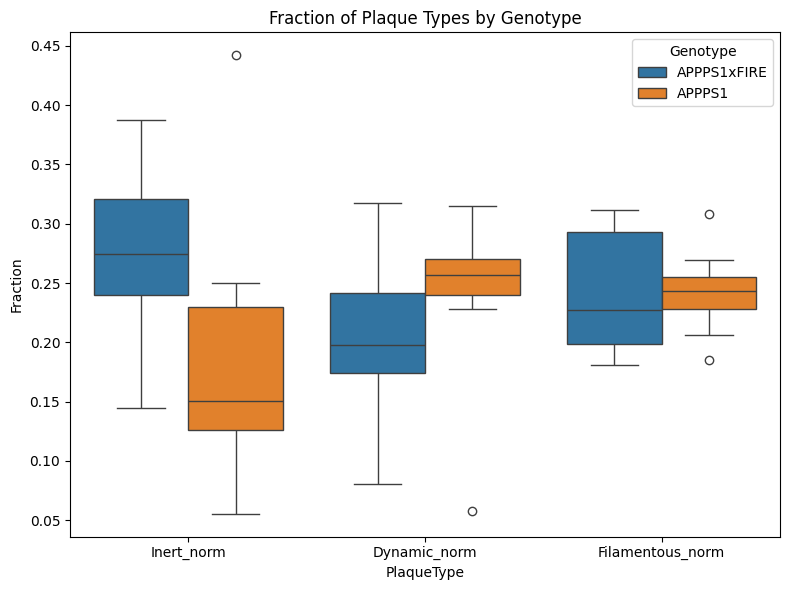


--- T-tests for Plaque Type: Inert_norm ---
  APPPS1xFIRE vs. APPPS1: t=2.157, p=4.794e-02

--- T-tests for Plaque Type: Dynamic_norm ---
  APPPS1xFIRE vs. APPPS1: t=-1.218, p=2.384e-01

--- T-tests for Plaque Type: Filamentous_norm ---
  APPPS1xFIRE vs. APPPS1: t=0.039, p=9.696e-01

Done! See the boxplot(s) and t-test results above.


In [1]:
#!/usr/bin/env python3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

def main():
    # 1. Load data
    csv_path = "/Users/katherineridley/Projects/PlaqueDist/Masks/image_summary_with_genotype.csv"
    df = pd.read_csv(csv_path)
    
    print("DataFrame head (first rows):")
    print(df.head())
    print("\nColumns available:", df.columns.tolist())
    
    # We expect columns like:
    #   ["ImagePrefix", "Inert", "Dynamic", "Filamentous", "Other", "genotype", ...]
    # If you already have columns named "Inert_norm", "Dynamic_norm", "Filamentous_norm",
    # you can comment out or overwrite the calculation below.
    
    # 2. Compute total plaques and fractions for each image
    #    (Skip or modify this if you already have norm columns.)
    df["total_plaques"] = df[["Inert", "Dynamic", "Filamentous", "Other"]].sum(axis=1)
    
    # Avoid dividing by zero if total_plaques=0 for some row
    # By default, we'll set norm to NaN if total_plaques=0
    df["Inert_norm"] = np.where(
        df["total_plaques"] > 0,
        df["Inert"] / df["total_plaques"],
        np.nan
    )
    df["Dynamic_norm"] = np.where(
        df["total_plaques"] > 0,
        df["Dynamic"] / df["total_plaques"],
        np.nan
    )
    df["Filamentous_norm"] = np.where(
        df["total_plaques"] > 0,
        df["Filamentous"] / df["total_plaques"],
        np.nan
    )
    
    # 3. Reshape data for plotting: we want a 'long' format
    #    So each row becomes: (ImagePrefix, genotype, PlaqueType, Count)
    #    We'll only plot normalized subtypes (Inert_norm, Dynamic_norm, Filamentous_norm).
    plaque_types = ["Inert_norm", "Dynamic_norm", "Filamentous_norm"]
    
    melted = df.melt(
        id_vars=["ImagePrefix", "genotype"],
        value_vars=plaque_types,  # which columns to pivot
        var_name="PlaqueType",
        value_name="Fraction"
    )

    #save csv
    melted.to_csv('/Users/katherineridley/Projects/PlaqueDist/Masks/melted.csv')


    
    # 4. Plot: boxplot of the fractions by genotype
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=melted,
        x="PlaqueType",
        y="Fraction",
        hue="genotype",
        showfliers=True  # or False to hide outliers
    )
    plt.title("Fraction of Plaque Types by Genotype")
    plt.legend(title="Genotype", loc="best")
    plt.tight_layout()
    plt.show()
    
    # 5. (Optional) run pairwise t-tests between genotypes for each plaque type
    all_genotypes = df["genotype"].unique()
    
    for ptype in plaque_types:
        print(f"\n--- T-tests for Plaque Type: {ptype} ---")
        
        # Subset the data for just this plaque type
        subset = melted[melted["PlaqueType"] == ptype]
        
        # We'll do pairwise comparisons among all genotypes
        for g1, g2 in combinations(all_genotypes, 2):
            group1 = subset.loc[subset["genotype"] == g1, "Fraction"].dropna()
            group2 = subset.loc[subset["genotype"] == g2, "Fraction"].dropna()
            
            if len(group1) < 2 or len(group2) < 2:
                print(f"  Not enough data to compare {g1} vs. {g2} for {ptype}.")
                continue
            
            # Perform Welch's t-test
            tstat, pval = ttest_ind(group1, group2, equal_var=False)
            print(f"  {g1} vs. {g2}: t={tstat:.3f}, p={pval:.3e}")
    
    print("\nDone! See the boxplot(s) and t-test results above.")

if __name__ == "__main__":
    main()
